In [ ]:
# Use PRAW to interact with Reddit API to fetch data
import praw
import os

praw_client_id = os.getenv("PRAW_CLIENT_ID")
praw_secret = os.getenv("PRAW_SECRET")
praw_user_agent = os.getenv("PRAW_USER_AGENT")

reddit = praw.Reddit(
    client_id = 'praw_client_id',
    client_secret = 'praw_secret',
    user_agent = 'praw_user_agent'
)
print("Connected to Reddit API successfully")

Connected to Reddit API successfully


In [ ]:
# Extract specific data of subreddit posts and store it
import pandas as pd

subreddits = ['mentalhealth','depression','Anxiety','SuicideWatch']
all_posts = []

for sub in subreddits:
    print(f"Extracting from r/{sub}...")
    for post in reddit.subreddit(sub).hot(limit=251):
        if post.selftext:
            all_posts.append({
                'subreddit': sub,
                'title': post.title,
                'selftext': post.selftext,
                'created_utc': post.created_utc,
                'score': post.score,
                'num_comments': post.num_comments
            })
print(f"Extracted {len(all_posts)} total_posts.")

Extracting from r/mentalhealth...
Extracting from r/depression...
Extracting from r/Anxiety...
Extracting from r/SuicideWatch...
Extracted 1000 total_posts.


In [6]:
# Check all the columns and data
reddit_data = pd.DataFrame(all_posts)
reddit_data.head()

,subreddit,title,selftext,created_utc,score,num_comments
0,mentalhealth,Elections and Politics,Hello friends!\n\nIt's that time of the year a...,1.730031e+09,29,17
1,mentalhealth,r/MentalHealth is looking for moderators,Hey r/mentalhealth! We're looking to grow our ...,1.720874e+09,21,27
2,mentalhealth,I think my dad is trying to tell me something,Lol,1.746747e+09,321,13
3,mentalhealth,"Diagnosed and medicated, and now I’m grieving ...","I’ve posted this in other groups, and sorry th...",1.746791e+09,16,1
4,mentalhealth,I am passively suicidal as a doctor,I had a traumatic childhood and my grades were...,1.746790e+09,15,9


In [7]:
# Verify nulls
reddit_data.isnull().sum() 

subreddit       0
title           0
selftext        0
created_utc     0
score           0
num_comments    0
dtype: int64

In [8]:
# Reset the index of data
reddit_data.reset_index(drop=True, inplace=True)
reddit_data.head()

,subreddit,title,selftext,created_utc,score,num_comments
0,mentalhealth,Elections and Politics,Hello friends!\n\nIt's that time of the year a...,1.730031e+09,29,17
1,mentalhealth,r/MentalHealth is looking for moderators,Hey r/mentalhealth! We're looking to grow our ...,1.720874e+09,21,27
2,mentalhealth,I think my dad is trying to tell me something,Lol,1.746747e+09,321,13
3,mentalhealth,"Diagnosed and medicated, and now I’m grieving ...","I’ve posted this in other groups, and sorry th...",1.746791e+09,16,1
4,mentalhealth,I am passively suicidal as a doctor,I had a traumatic childhood and my grades were...,1.746790e+09,15,9


In [158]:
# Read Open-ai key from environment variables 
import openai
import os
from dotenv import load_dotenv

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

In [5]:
print(openai.__version__) # Print the version

0.28.1


In [9]:
# Intiate prompt to openai with sepcific required criteria
import re
def extract_emotion(text):
    try:
        response = openai.ChatCompletion.create(
            model= "gpt-3.5-turbo",
            messages=[
                {"role":"system", "content": "You are an emotion classification expert."},
                {"role": "user", "content": f"Classify the dominant emotion in this reddit post:\n{text}\nRespond with *only* one word from this list: happy, sad, anxious, depressed, suicidal, neutral, anger, hope, loneliness, motivation, burnout."}
            ],
            max_tokens= 10
        )
        emotion = response['choices'][0]['message']['content'].strip().lower()

        # pre-processing by keeping only valid labels
        valid_emotions = ['happy', 'sad', 'anxious', 'depressed', 'suicidal', 'neutral', 'anger', 'hope', 'loneliness', 'motivation', 'burnout']

        # Clean and tokenize model output to match valid emotion
        words = re.findall(r'\b\w+\b', emotion)
        for word in words:
            if word in valid_emotions:
                return word
            
        return 'neutral' #Fallback if no valid emotion found

    except Exception as e:
        print("Error while API Call:", e)
        return "error"
    
print("Tagging emotions using OpenAI.....")

Tagging emotions using OpenAI.....


In [ ]:
# Apply the openai prompt function to extract the emotion behind texts in posts

reddit_data['emotion']= reddit_data['selftext'].apply(lambda x: extract_emotion(x[:2000]))
print("Emotion data retrieved successfully")

Error while API Call: The server is overloaded or not ready yet.
Emotion data retrieved successfully


In [11]:
# Print unique columns
print(reddit_data['emotion'].unique())

['anxious' 'hope' 'happy' 'suicidal' 'neutral' 'sad' 'depressed' 'anger'
 'burnout' 'motivation' 'loneliness' 'error']


In [12]:
reddit_data.shape # Shape of the dataframe to check rows

(1000, 7)

In [13]:
# Value counts of each emotion tagged by openai from the posts
reddit_data['emotion'].value_counts() 

emotion
anxious       285
depressed     225
suicidal      174
neutral        80
sad            71
loneliness     64
anger          40
hope           39
burnout        13
happy           4
motivation      4
error           1
Name: count, dtype: int64

In [14]:
# Drop the values where emotion is error
reddit_data_cleaned = reddit_data[reddit_data['emotion'] != 'error']

In [15]:
# Check counts 
reddit_data_cleaned['emotion'].value_counts()

emotion
anxious       285
depressed     225
suicidal      174
neutral        80
sad            71
loneliness     64
anger          40
hope           39
burnout        13
happy           4
motivation      4
Name: count, dtype: int64

In [16]:
reddit_data_cleaned.shape #Shape to cross-check the rows and columns

(999, 7)

In [17]:
# Convert created_utc column into datetime format
import pandas as pd
reddit_data_cleaned['created_utc']= pd.to_datetime(reddit_data_cleaned['created_utc'], unit='s')

/var/folders/9m/xmb6cfqs55d_cp4t3s4m_9180000gn/T/ipykernel_2769/1270460289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data_cleaned['created_utc']= pd.to_datetime(reddit_data_cleaned['created_utc'], unit='s')


In [18]:
reddit_data_cleaned.head(10)

,subreddit,title,selftext,created_utc,score,num_comments,emotion
0,mentalhealth,Elections and Politics,Hello friends!\n\nIt's that time of the year a...,2024-10-27 12:13:33,29,17,anxious
1,mentalhealth,r/MentalHealth is looking for moderators,Hey r/mentalhealth! We're looking to grow our ...,2024-07-13 12:25:58,21,27,hope
2,mentalhealth,I think my dad is trying to tell me something,Lol,2025-05-08 23:30:32,321,13,happy
3,mentalhealth,"Diagnosed and medicated, and now I’m grieving ...","I’ve posted this in other groups, and sorry th...",2025-05-09 11:42:11,16,1,hope
4,mentalhealth,I am passively suicidal as a doctor,I had a traumatic childhood and my grades were...,2025-05-09 11:19:29,15,9,anxious
5,mentalhealth,I've been suicidal since I was 11,Anyone else like this? I know suicidality in a...,2025-05-09 07:54:54,23,13,suicidal
6,mentalhealth,Why isn't suicide accepted by society ? please...,Please read before flagging this as problemati...,2025-05-08 18:08:57,157,75,neutral
7,mentalhealth,If you could associate one image to your menta...,I've been dealing with CPTSD for a while. Even...,2025-05-09 02:40:27,24,20,anxious
8,mentalhealth,Just a reach out post,Today in Australia we unfortunately mark the a...,2025-05-09 10:04:21,5,2,sad
9,mentalhealth,Is This What Adult Life Is Like?,"Alright, please don't laugh at me. But I'm 19 ...",2025-05-09 07:39:08,8,18,depressed


In [19]:
reddit_data_cleaned.tail(10)

,subreddit,title,selftext,created_utc,score,num_comments,emotion
990,SuicideWatch,About my bf not finding his place,About my bf\n\nMy boyfriend from Portugal is h...,2025-05-08 20:09:51,2,0,depressed
991,SuicideWatch,I’m the devil,Im going to kill couples,2025-05-08 23:49:45,1,0,anger
992,SuicideWatch,I don’t know how to cope,I keep trying to stockpile my medications so I...,2025-05-08 16:11:26,4,5,suicidal
993,SuicideWatch,Am i still depressed 7 yrs later,Ive experienced depression but the question is...,2025-05-08 12:20:54,8,1,depressed
994,SuicideWatch,I just want to die,How do I kill myself if I don't have access to...,2025-05-08 23:35:05,1,0,suicidal
995,SuicideWatch,Hope,Been thinking about suicide every day for almo...,2025-05-08 23:21:22,1,0,suicidal
996,SuicideWatch,Please help.,"Appreciate your health…\n\nHello everyone, I k...",2025-05-08 19:35:16,2,1,suicidal
997,SuicideWatch,i hated hated everyone,I was thinking My regrets is destroy my life. ...,2025-05-08 17:12:48,3,1,sad
998,SuicideWatch,Can someone give me a reason to take my gun ou...,Sitting here with my gun in my mouth. Only rea...,2025-05-08 14:24:01,5,4,suicidal
999,SuicideWatch,I am having difficulty finding meaning in anyt...,"This happened to me before. In my head, I call...",2025-05-08 23:05:30,1,0,depressed


In [ ]:
# Upload cleaned data to bigquery
from google.cloud import bigquery
from pandas_gbq import to_gbq

to_gbq(
    dataframe=reddit_data_cleaned,
    destination_table='dataset_1.mentalhealth_data',
    project_id='data-analysis-458211',
    if_exists='replace'  
)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=pdOz8NrO6Of02ptnT7j1acThrerioI&prompt=consent&access_type=offline


100%|██████████| 1/1 [00:00<00:00, 7884.03it/s]


In [159]:
# Establishing a connection with the BigQuery Datasets using JSON Key stored in env
import os
google_credentials_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = google_credentials_path

client = bigquery.Client()

query = """
        SELECT * FROM data-analysis-458211.dataset_1.mentalhealth_data
        """

mentalhealth_data = client.query(query).to_dataframe()
mentalhealth_data.head()

,subreddit,title,selftext,created_utc,score,num_comments,emotion
0,depression,"""Its a permanent solution to a temporary probl...",Words genuinely can't describe the rage I feel...,2025-05-09 00:56:46,232,47,anger
1,SuicideWatch,Please remember that NO ACTIVISM of any kind i...,"Activism, i.e. advocating or fundraising for s...",2021-09-10 00:01:50,714,43,anger
2,mentalhealth,"Off Meds, Emotions Back Online, and I’m Done P...","I used to be chill. Quiet, calm, unbothered. P...",2025-05-09 02:29:36,2,0,anger
3,mentalhealth,"Diagnosed with IED today, and not sure how to ...","Hey everyone, first time posting on this subre...",2025-05-08 20:38:41,1,0,anger
4,mentalhealth,Pls help. Should I get out of this relationship?,I love my girlfriend and she loves me. A lot. ...,2025-05-08 18:03:36,1,0,anger


In [ ]:
# Query aggregation of anger average values
query = """
        SELECT subreddit, AVG(score) AS average_score, AVG(num_comments) AS average_comments
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        WHERE emotion = 'anger'
        GROUP BY subreddit
        """

average_anger = client.query(query).to_dataframe()
average_anger

,subreddit,average_score,average_comments
0,depression,19.785714,4.500000
1,SuicideWatch,113.500000,8.125000
2,mentalhealth,6.000000,3.933333
3,Anxiety,17.333333,5.000000


In [128]:
# Query aggregation of anger hope values
query = """
        SELECT subreddit, AVG(score) AS average_score, AVG(num_comments) AS average_comments
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        WHERE emotion = 'hope'
        GROUP BY subreddit
        """

average_hope = client.query(query).to_dataframe()
average_hope

,subreddit,average_score,average_comments
0,mentalhealth,4.733333,2.733333
1,depression,340.142857,26.000000
2,Anxiety,8.666667,5.500000
3,SuicideWatch,3.454545,2.545455


In [ ]:
# Query aggregation of suicidal values
query = """
        SELECT subreddit, AVG(score) AS average_score, AVG(num_comments) AS average_comments
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        WHERE emotion = 'suicidal'
        GROUP BY subreddit
        """

average_suicidal = client.query(query).to_dataframe()
average_suicidal

,subreddit,average_score,average_comments
0,depression,11.694444,6.055556
1,SuicideWatch,10.907563,4.327731
2,mentalhealth,2.444444,2.500000
3,Anxiety,1.000000,11.000000


In [ ]:
# Query aggregation of sad average values
query = """
        SELECT subreddit, AVG(score) AS average_score, AVG(num_comments) AS average_comments
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        WHERE emotion = 'sad'
        GROUP BY subreddit
        """

average_sad = client.query(query).to_dataframe()
average_sad

,subreddit,average_score,average_comments
0,mentalhealth,1.541667,2.958333
1,depression,6.000000,2.291667
2,SuicideWatch,6.166667,3.833333
3,Anxiety,4.400000,2.600000


In [132]:
# Query aggregation of depressed average values
query = """
        SELECT subreddit, AVG(score) AS average_score, AVG(num_comments) AS average_comments
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        WHERE emotion = 'depressed'
        GROUP BY subreddit
        """

average_depressed = client.query(query).to_dataframe()
average_depressed

,subreddit,average_score,average_comments
0,mentalhealth,2.719298,3.035088
1,depression,8.750000,3.178571
2,Anxiety,2.000000,5.666667
3,SuicideWatch,6.094340,1.698113


In [ ]:
# Query and aggregate emotion count distribution
client = bigquery.Client()

query = """
        SELECT emotion, COUNT(emotion) AS Emotion_Count
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        GROUP BY emotion
        ORDER BY Emotion_Count DESC
        """

emotion_distribution = client.query(query).to_dataframe()
emotion_distribution

,emotion,Emotion_Count
0,anxious,285
1,depressed,225
2,suicidal,174
3,neutral,80
4,sad,71
5,loneliness,64
6,anger,40
7,hope,39
8,burnout,13
9,happy,4


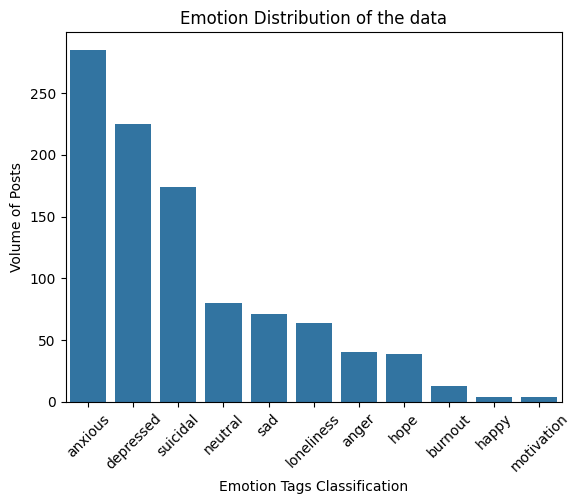

In [37]:
# Bar plot to visualize emotion distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='emotion', y='Emotion_Count', data= emotion_distribution)
plt.title("Emotion Distribution of the data")
plt.xlabel("Emotion Tags Classification")
plt.ylabel("Volume of Posts")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Query and aggregate emotion score distribution
query = """
        SELECT emotion, SUM(score) AS total_score
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        GROUP BY emotion
        ORDER BY total_score DESC
        """

emotion_score_distribution = client.query(query).to_dataframe()
emotion_score_distribution

,emotion,total_score
0,neutral,2561
1,hope,2542
2,anxious,2333
3,suicidal,1764
4,depressed,1464
5,anger,1327
6,loneliness,536
7,happy,326
8,sad,314
9,burnout,55


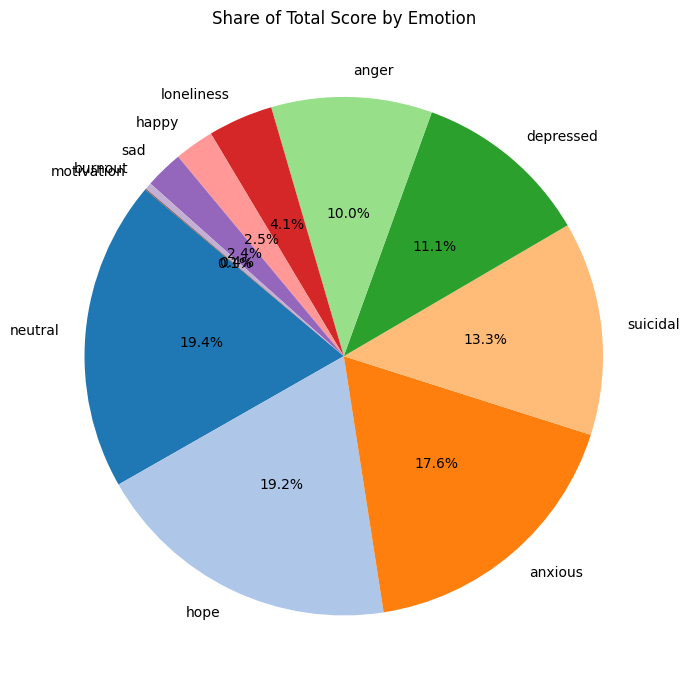

In [157]:
# Pie Chart of emotion distribution
emotion_score_distribution = emotion_score_distribution.sort_values(by='total_score', ascending=False)
colors = plt.cm.tab20.colors # Custom color palette
plt.figure(figsize=(7, 7))
plt.pie(emotion_score_distribution['total_score'],
        labels=emotion_score_distribution['emotion'],
        autopct='%1.1f%%',
        startangle=140,
        colors=colors[:len(emotion_score_distribution)],
        labeldistance=1.1,
        pctdistance=0.55
        )

plt.title("Share of Total Score by Emotion")
plt.axis('equal')
plt.tight_layout()
plt.show()

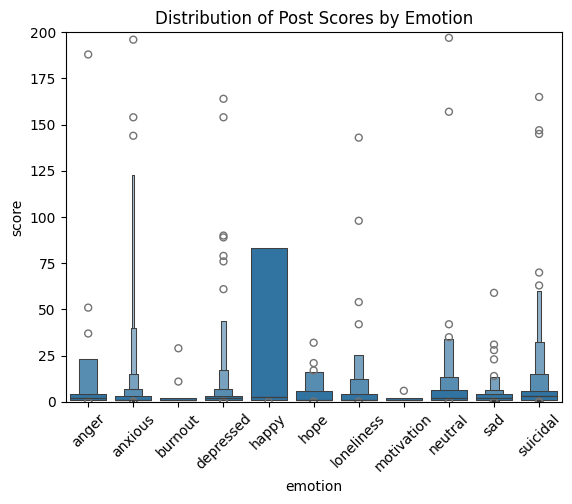

In [ ]:
# Box plot to visualize post score distribution
sns.boxenplot(x='emotion', y='score', data=mentalhealth_data)
plt.xticks(rotation=45)
plt.ylim(0,200)
plt.title("Distribution of Post Scores by Emotion")
plt.show()


In [82]:
# Box plot to visualize post comment distribution
query = """
        SELECT emotion, SUM(num_comments) AS total_comments
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        GROUP BY emotion
        ORDER BY total_comments DESC
        """

comment_distribution = client.query(query).to_dataframe()
comment_distribution

,emotion,total_comments
0,anxious,1583
1,suicidal,789
2,neutral,709
3,depressed,636
4,loneliness,310
5,hope,284
6,sad,208
7,anger,202
8,burnout,41
9,happy,19


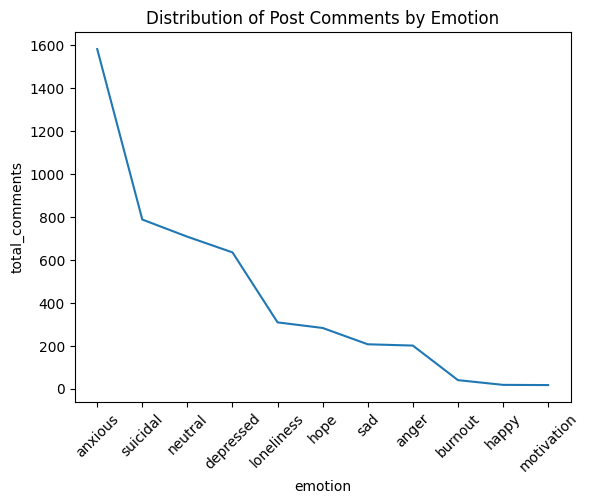

In [98]:
# Box plot to visualize post line distribution
sns.lineplot(x='emotion', y='total_comments', data=comment_distribution)
plt.xticks(rotation=45)
# plt.ylim(0,200)
plt.title("Distribution of Post Comments by Emotion")
plt.show()

In [ ]:
# Box plot to visualize post hour distribution
query = """
        SELECT EXTRACT(HOUR FROM created_utc) AS hour,
        emotion, COUNT(*) AS post_count
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        GROUP BY hour, emotion
        ORDER BY hour, emotion
        """

hour_distribution = client.query(query).to_dataframe()
hour_distribution

,hour,emotion,post_count
0,0,anger,2
1,0,anxious,18
2,0,depressed,9
3,0,happy,1
4,0,hope,1
...,...,...,...
191,23,hope,3
192,23,loneliness,4
193,23,neutral,3
194,23,sad,4


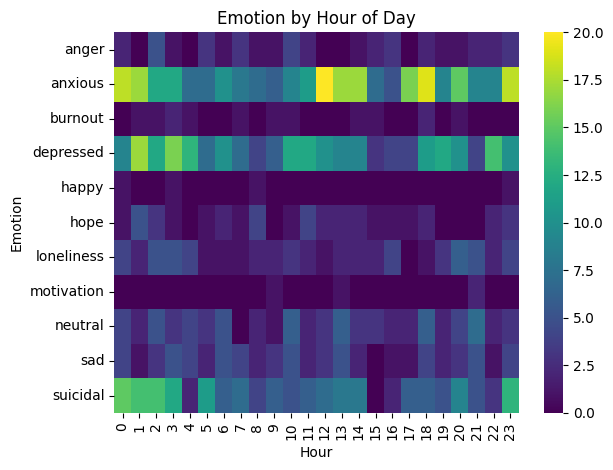

In [ ]:
# Heat map of emotion and hour distribution
hour_distribution_pivot = hour_distribution.pivot(index='emotion', columns='hour', values='post_count').fillna(0)
hour_distribution_pivot = hour_distribution_pivot.astype(float)

# Plot
sns.heatmap(hour_distribution_pivot, cmap="viridis")
plt.title("Emotion by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Emotion")
plt.tight_layout()
plt.show()


In [104]:
# Query and aggregation post count with diverse subreddit
query = """
        SELECT subreddit, emotion, COUNT(*) AS post_count
        FROM data-analysis-458211.dataset_1.mentalhealth_data
        GROUP BY subreddit, emotion
        ORDER BY subreddit, emotion
        """

subreddit_emotion_distribution = client.query(query).to_dataframe()
subreddit_emotion_distribution

,subreddit,emotion,post_count
0,Anxiety,anger,3
1,Anxiety,anxious,200
2,Anxiety,burnout,3
3,Anxiety,depressed,3
4,Anxiety,happy,1
5,Anxiety,hope,6
6,Anxiety,loneliness,4
7,Anxiety,neutral,21
8,Anxiety,sad,5
9,Anxiety,suicidal,1


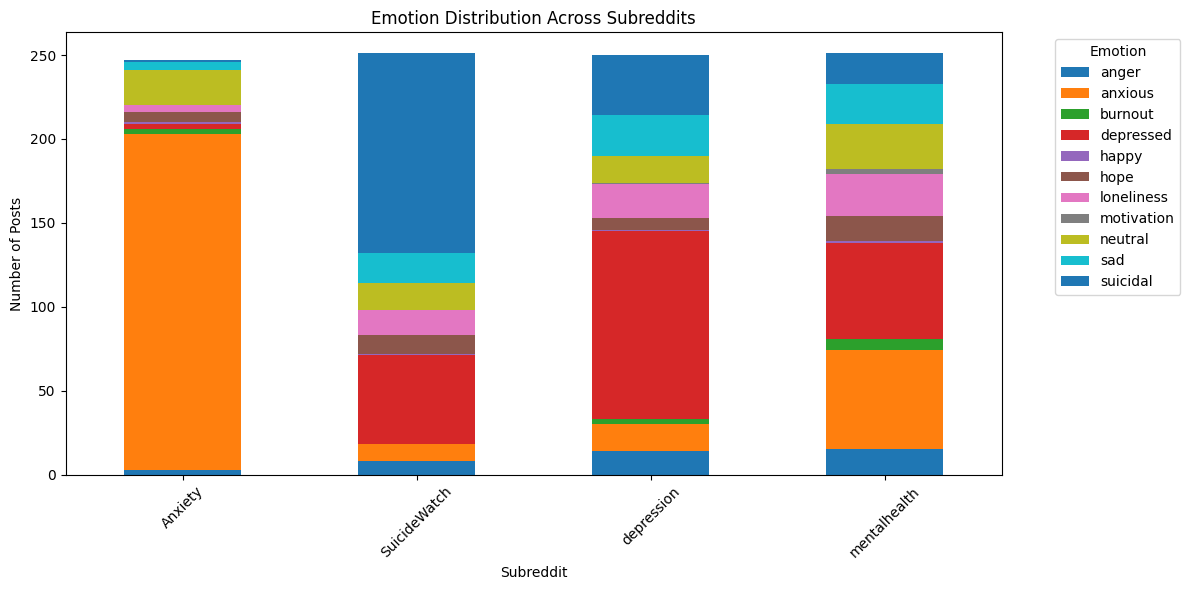

In [ ]:
# Stacked bar plot to visualize emotion distribution of each subreddit
emotion_by_sub = subreddit_emotion_distribution.pivot(
    index='subreddit',
    columns='emotion',
    values='post_count'
).fillna(0)
emotion_by_sub.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Emotion Distribution Across Subreddits")
plt.ylabel("Number of Posts")
plt.xlabel("Subreddit")
plt.xticks(rotation=45)
plt.legend(title='Emotion', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


In [133]:
top_posts = mentalhealth_data.sort_values('score', ascending=False).groupby('emotion').head(1)
print(top_posts[['emotion', 'score', 'selftext']])

        emotion  score                                           selftext
568        hope   2363  We understand that most people who reply immed...
680     neutral   1781  We've been seeing a worrying increase in pro-s...
1         anger    714  Activism, i.e. advocating or fundraising for s...
42      anxious    466  in my experience, people actually hate it when...
566       happy    321                                                Lol
829    suicidal    229  My country is so goddamn filthy and I can’t st...
343   depressed    164  This is entirely my own doing but I just wante...
608  loneliness    143  Let me start by saying that I’m not an unattra...
756         sad     59                                                 It
325     burnout     29  Work as a carpenter so it’s physical work but ...
673  motivation      6  You don't need to read the following paragraph...


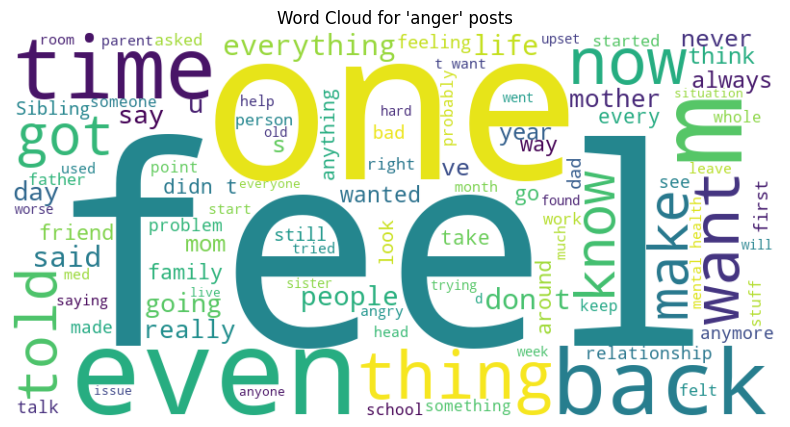

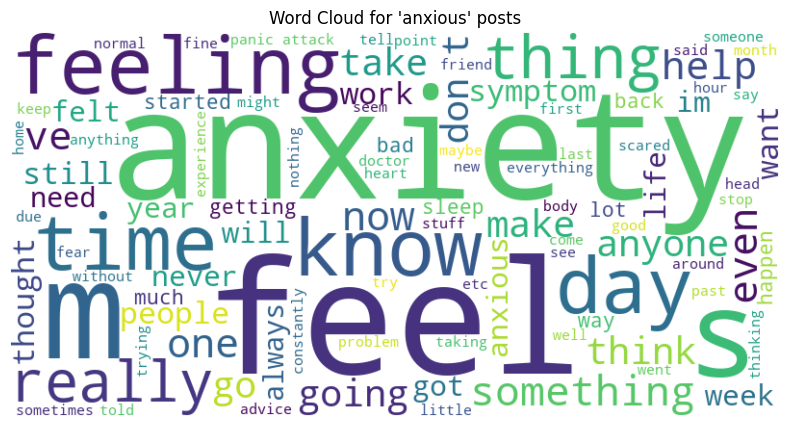

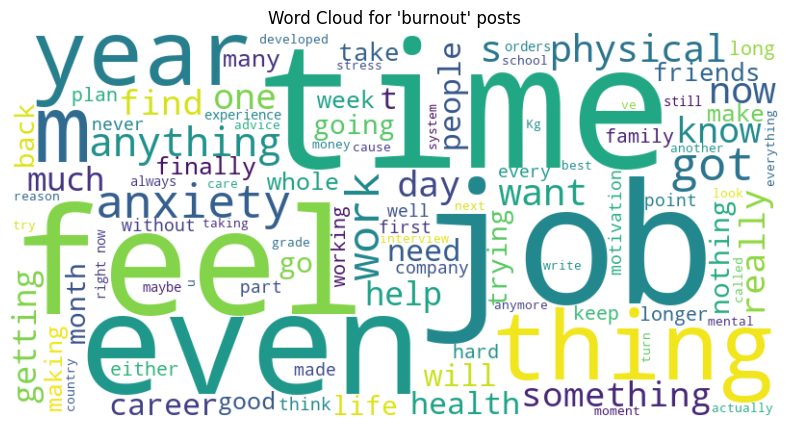

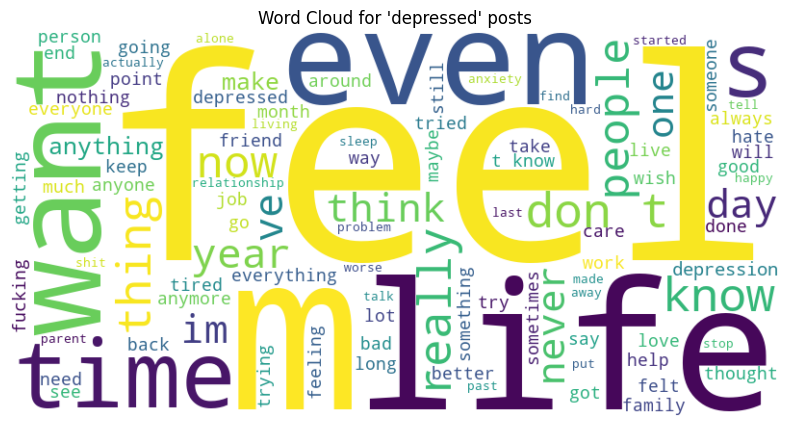

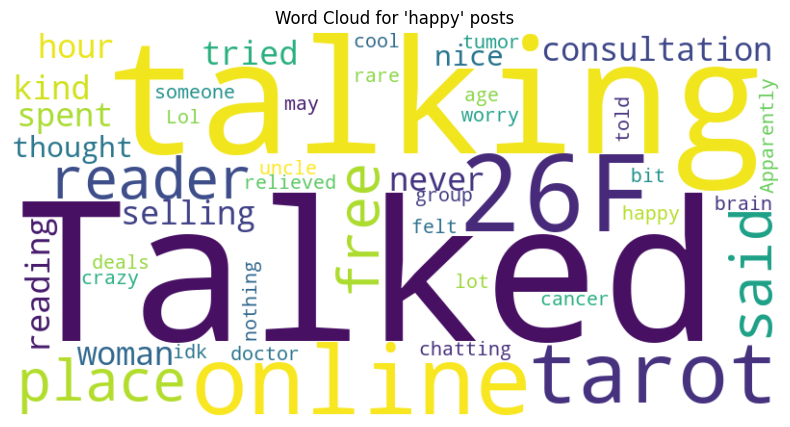

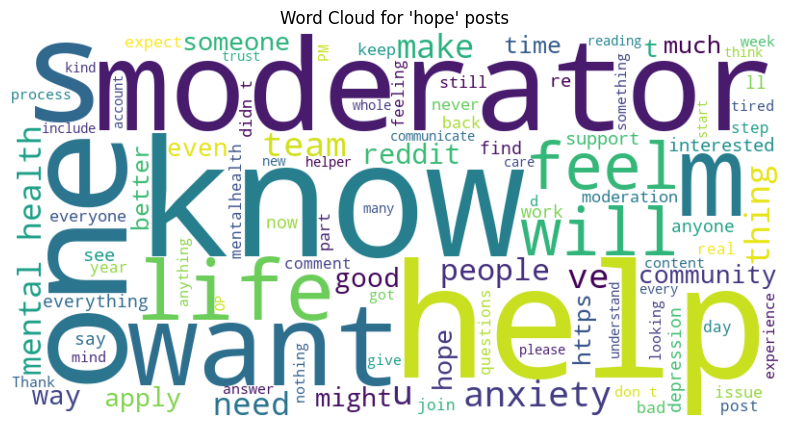

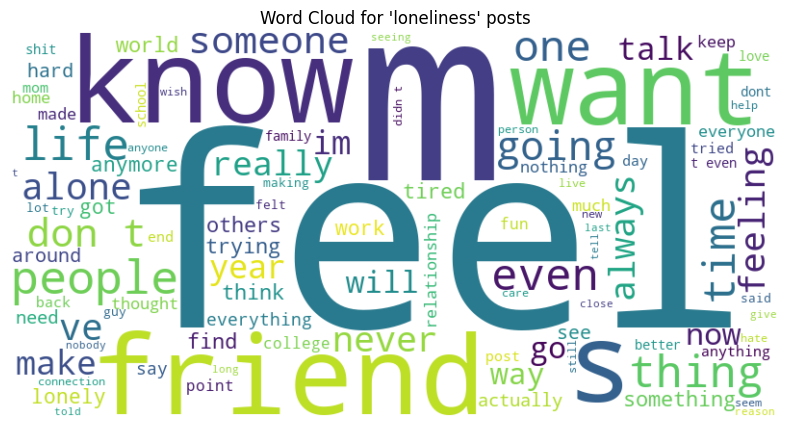

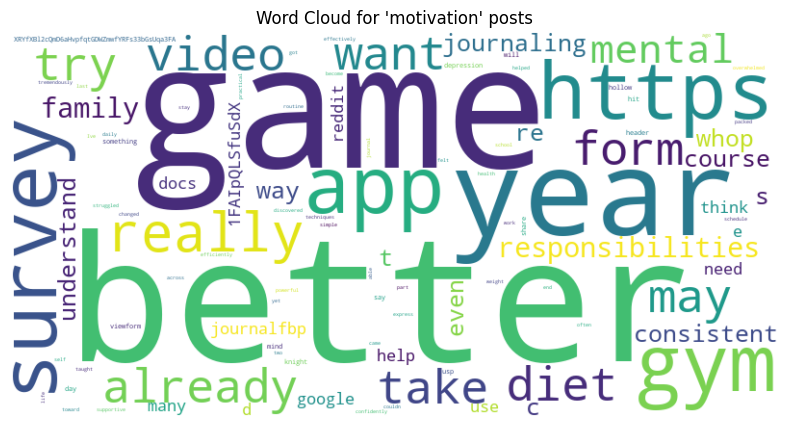

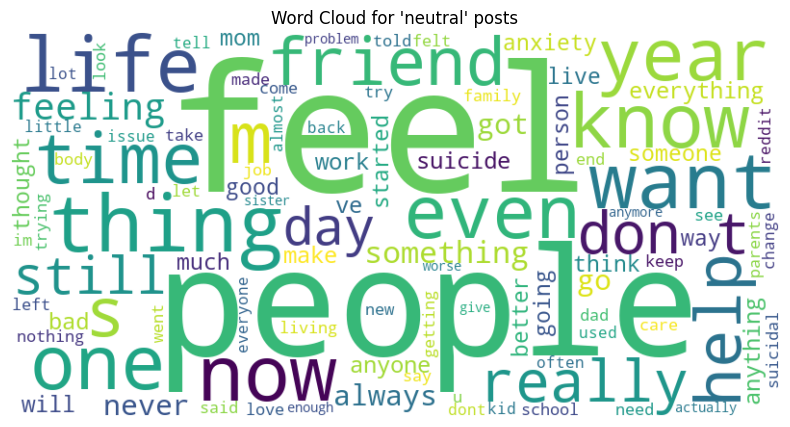

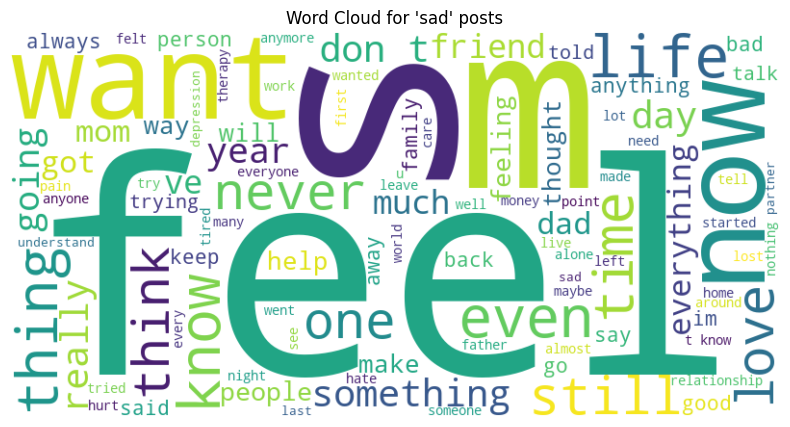

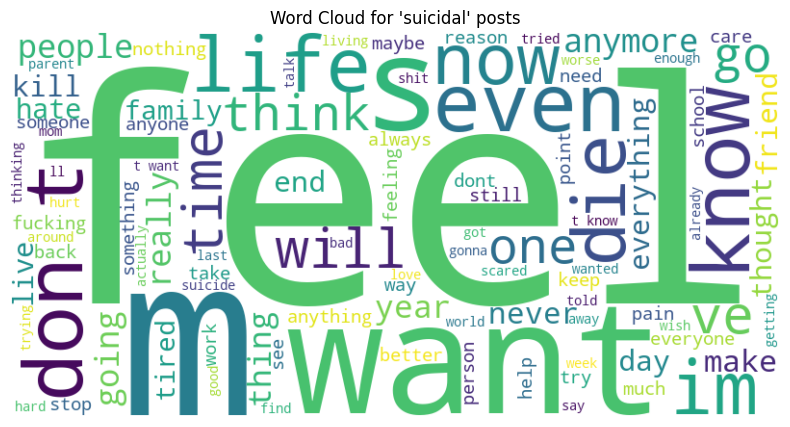

In [ ]:
# Wordcloud picture for each emotion to view each most used words  
from wordcloud import WordCloud

emotions = mentalhealth_data['emotion'].unique()

for emotion in emotions:
    text = " ".join(mentalhealth_data[mentalhealth_data['emotion']== emotion]['selftext'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white',max_words=100).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for '{emotion}' posts")
    plt.show()

In [167]:
import pandas as pd
from collections import Counter
import re

# Combine all text
all_text = " ".join(mentalhealth_data['selftext'].dropna()).lower()

# Basic cleaning & tokenization
words = re.findall(r'\b[a-z]{3,}\b', all_text)  # Only words, 3+ letters
word_counts = Counter(words)

# Convert to DataFrame
df_wordcloud = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Optionally filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df_wordcloud = df_wordcloud[~df_wordcloud['word'].isin(stop_words)]

# Save to CSV
df_wordcloud.to_csv('combined_wordcloud.csv', index=False)
df_wordcloud.head(10)


,word,count
0,words,23
1,genuinely,67
3,describe,18
5,rage,10
6,feel,1088
7,whenever,30
8,someone,263
9,says,40
11,whether,28
12,else,167


In [165]:
# Upload data to bigquery
to_gbq(
    dataframe=df_wordcloud,
    destination_table='dataset_1.wordcloud_data',
    project_id='data-analysis-458211',
    if_exists='replace'  
)

100%|██████████| 1/1 [00:00<00:00, 3492.34it/s]
